In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #그래프용 seaborn 라이브러리
import matplotlib.pyplot as plt #그래프 표시
import re
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

아랫 부분은 추가 작업인데, 뒷부분에서 나오는 torch와 torchtext 버전 문제로 실행되지 않는 코드가 있어서
tourch와 torchtext 버전 확인 하는 코드를 한줄 넣었습니다.

In [2]:
import torch
import torchtext

print("PyTorch Version:", torch.__version__)
print("Torchtext Version:", torchtext.__version__)

PyTorch Version: 2.0.1
Torchtext Version: 0.15.2


In [ ]:
# 기존의 torch 및 torchtext 제거
!pip uninstall -y torch torchvision torchaudio torchtext

# PyTorch 2.0.1 및 Torchtext 0.15.2 설치
!pip install torch==2.0.1 torchvision torchaudio torchtext==0.15.2

1. 데이터셋 불러오기

In [3]:
# 데이터 로드
data = pd.read_csv('netflix_reviews.csv')

2. 데이터 전처리

In [4]:
# 수정된 데이터 전처리 함수
def preprocess_text(content):
    if isinstance(content, float):
        return ''
    # 모든 텍스트를 소문자로 변환
    content = content.lower()
    # 알파벳과 공백만 남기기
    content = re.sub(r'[^a-z\s]', '', content)  # 알파벳과 공백만 유지
    # 다수의 공백을 하나의 공백으로 줄이기
    content = re.sub(r'\s+', ' ', content)
    content = content.strip()  # 앞뒤 공백 제거
    return content.split()  # 단어 단위로 분리

3. feature 분석 

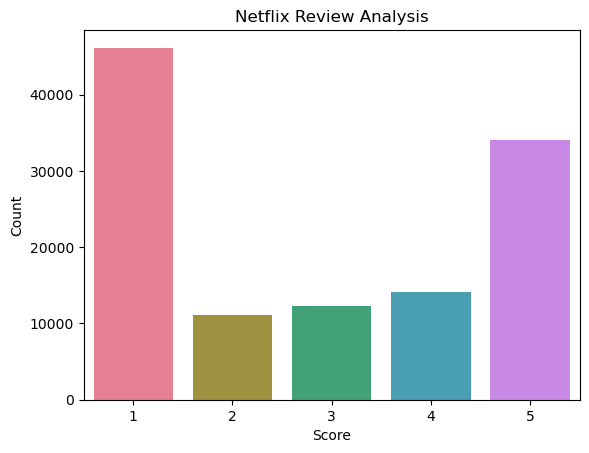

In [5]:
# 시각화
palette = sns.color_palette('husl', 5)
sns.barplot(x=data['score'].value_counts().index, 
            y=data['score'].value_counts().values, 
            palette=palette, 
            hue=data['score'].value_counts().index, 
            dodge=False, 
            legend=False)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Netflix Review Analysis')
plt.show()

#palette 인자를 사용하면서 hue를 설정하지 않아서 발생한 경고를 처리함
# hue를 x로 설정하고, legend를 False로 지정

4. 클래스 정의

In [6]:
# Dataset 클래스 정의
class ReviewDataset(Dataset):
    def __init__(self, content, score, preprocess_text):
        self.content = content
        self.score = score
        self.preprocess_text = preprocess_text

    def __len__(self):
        return len(self.content)

    def __getitem__(self, idx):
        content = self.preprocess_text(self.content.iloc[idx])
        score = self.score.iloc[idx]
        return content, score

In [7]:
# 데이터 분할
train_content, test_content, train_score, test_score = train_test_split(
    data['content'], data['score'], test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 64

# Dataset 객체 생성
train_dataset = ReviewDataset(train_content, train_score, preprocess_text)
test_dataset = ReviewDataset(test_content, test_score, preprocess_text)

In [8]:
def content_text(content):
    for text in content:
        # 만약 숫자형(float)이거나 NaN인 경우 빈 문자열로 처리
        if isinstance(text, float):
            text = ""
        yield text.split()

from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(content_text(data['content']), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [9]:
# LSTM 모델 클래스 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [22]:
import torch
from torch.nn.utils.rnn import pad_sequence

# collate_fn 함수 수정
def collate_fn(batch):
    texts, labels = zip(*batch)
    # 각 텍스트를 텐서로 변환
    texts = [torch.tensor(text) for text in texts]  # 리스트 안의 각 텍스트를 텐서로 변환
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)  # 패딩 값을 0으로 지정
    labels = torch.tensor(labels)  # 레이블을 텐서로 변환
    return texts_padded, labels

# 데이터 로더 정의
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [24]:
# 하이퍼파라미터 정의
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = len(set(train_score))  # 예측할 점수 개수 (train_score에서 가져옴)

# 모델 초기화
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [23]:
# 모델 학습 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # 모델을 학습 모드로 전환
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (texts, labels) in enumerate(train_loader):
            optimizer.zero_grad()  # 옵티마이저의 기울기 초기화

            # 순전파
            output = model(texts)
            loss = criterion(output, labels)
            
            # 역전파
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')      

In [25]:
# 학습 실행
train_model(model, train_dataloader, criterion, optimizer, num_epochs=5)

ValueError: too many dimensions 'str'

In [15]:
# 텍스트를 인덱스로 변환하는 함수
def text_pipeline(text):
    tokens = preprocess_text(text)  # 텍스트 전처리 및 토큰화
    indices = [vocab[token] for token in tokens if token in vocab]  # 단어를 인덱스로 변환
    return indices

# 예측 함수
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        # 리뷰를 텐서로 변환
        tensor_review = torch.tensor(text_pipeline(review), dtype=torch.long).unsqueeze(0)
        
        # 모델에 입력
        output = model(tensor_review)
        
        # 예측 결과를 추출
        prediction = output.argmax(1).item()
        return prediction

# 새로운 리뷰에 대한 예측
new_review = "This app is great but has some bugs."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 0


In [16]:
# 예시 문장 리스트
positive_reviews = [
    "This app works perfectly and has amazing features!",
    "I absolutely love this app, it exceeded my expectations.",
    "The interface is user-friendly, and the app performs smoothly.",
    "Great customer support and fantastic overall experience!",
    "I highly recommend this app, it's the best I've used so far."
]

# 긍정 리뷰에 대한 예측
for review in positive_reviews:
    predicted_score = predict_review(model, review)
    print(f'Review: "{review}"\nPredicted Score: {predicted_score}\n')

Review: "This app works perfectly and has amazing features!"
Predicted Score: 2

Review: "I absolutely love this app, it exceeded my expectations."
Predicted Score: 1

Review: "The interface is user-friendly, and the app performs smoothly."
Predicted Score: 0

Review: "Great customer support and fantastic overall experience!"
Predicted Score: 0

Review: "I highly recommend this app, it's the best I've used so far."
Predicted Score: 0



In [17]:
# 부정적인 리뷰 리스트
negative_reviews = [
    "This app is terrible and crashes all the time.",
    "I hate using this app, it's full of bugs and very slow.",
    "The interface is confusing and the features are disappointing.",
    "Poor customer support and a really bad overall experience.",
    "I don't recommend this app, it fails to deliver on its promises."
]

# 부정 리뷰에 대한 예측
for review in negative_reviews:
    predicted_score = predict_review(model, review)
    print(f'Review: "{review}"\nPredicted Score: {predicted_score}\n')

Review: "This app is terrible and crashes all the time."
Predicted Score: 0

Review: "I hate using this app, it's full of bugs and very slow."
Predicted Score: 4

Review: "The interface is confusing and the features are disappointing."
Predicted Score: 4

Review: "Poor customer support and a really bad overall experience."
Predicted Score: 0

Review: "I don't recommend this app, it fails to deliver on its promises."
Predicted Score: 0



문제 해결 중 (문제점: 긍정적 리뷰도 1점만 줌)